# TensorBoard Runs Analysis (Sequential)

Notebook loads all TensorBoard logs from `runs/`, stitches runs sequentially, and plots each scalar tag as a separate figure.

Rules applied:
- For all runs except the first one, first 10 scalar points are dropped.
- On graph titles/labels, `loss` is renamed to `reward`.

In [38]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_rows', 200)

In [39]:
RUNS_ROOT = Path('../runs/cube_reinforcer/na_vse_babki')
TRIM_POINTS_NON_FIRST_RUN = 15

assert RUNS_ROOT.exists(), f'No runs dir found: {RUNS_ROOT.resolve()}'
event_files = sorted(RUNS_ROOT.glob('**/events.out.tfevents.*'))
run_dirs = sorted({f.parent for f in event_files}, key=lambda p: str(p))

print(f'Found {len(run_dirs)} runs')
for i, rd in enumerate(run_dirs, 1):
    print(f'{i:2d}. {rd}')

Found 9 runs
 1. ../runs/cube_reinforcer/na_vse_babki/run_20260217_205610
 2. ../runs/cube_reinforcer/na_vse_babki/run_20260217_205820
 3. ../runs/cube_reinforcer/na_vse_babki/run_20260217_205849
 4. ../runs/cube_reinforcer/na_vse_babki/run_20260217_210549
 5. ../runs/cube_reinforcer/na_vse_babki/run_20260217_215334
 6. ../runs/cube_reinforcer/na_vse_babki/run_20260217_221847
 7. ../runs/cube_reinforcer/na_vse_babki/run_20260217_221944
 8. ../runs/cube_reinforcer/na_vse_babki/run_20260218_004142
 9. ../runs/cube_reinforcer/na_vse_babki/run_20260218_004222


In [40]:
def load_run_scalars(run_dir: Path):
    ea = event_accumulator.EventAccumulator(str(run_dir))
    ea.Reload()
    tags = ea.Tags().get('scalars', [])
    data = {}
    for tag in tags:
        events = ea.Scalars(tag)
        steps = np.array([e.step for e in events], dtype=np.int64)
        values = np.array([e.value for e in events], dtype=np.float64)
        if steps.size > 0:
            order = np.argsort(steps, kind='stable')
            steps = steps[order]
            values = values[order]
        data[tag] = (steps, values)
    return data

def display_tag_name(tag: str) -> str:
    return tag.replace('loss', 'reward')

run_data = []
all_tags = set()
for rd in run_dirs:
    scalars = load_run_scalars(rd)
    run_data.append((rd, scalars))
    all_tags.update(scalars.keys())
all_tags = sorted(all_tags)
print(f'Total scalar tags: {len(all_tags)}')
all_tags

Total scalar tags: 11


['train/loss_batch',
 'train/lr',
 'train/return_inverse_penalty_mean_batch',
 'train/return_repeat_penalty_mean_batch',
 'train/return_step_mean_batch',
 'train/return_timeout_penalty_mean_batch',
 'train/return_total_mean_batch',
 'train/scramble_steps_current',
 'train/sr_batch',
 'train/steps_mean_batch',
 'train/steps_to_solve_mean_batch']

In [41]:
# Build stitched series: each run is appended after previous run for each tag
stitched = {}
boundaries = {}

for tag in all_tags:
    xs = []
    ys = []
    run_marks = []
    offset = 0

    for run_idx, (rd, scalars) in enumerate(run_data):
        if tag not in scalars:
            continue
        steps, vals = scalars[tag]
        if steps.size == 0:
            continue

        if run_idx > 0:
            if steps.size <= TRIM_POINTS_NON_FIRST_RUN:
                continue
            steps = steps[TRIM_POINTS_NON_FIRST_RUN:]
            vals = vals[TRIM_POINTS_NON_FIRST_RUN:]

        local = steps - steps.min()
        x = local + offset

        xs.append(x)
        ys.append(vals)
        run_marks.append((offset, str(rd)))
        offset = int(x.max()) + 1

    if xs:
        stitched[tag] = (np.concatenate(xs), np.concatenate(ys))
        boundaries[tag] = run_marks

print(f'Stitched tags: {len(stitched)}')

Stitched tags: 11


In [42]:
rows = []
for tag in sorted(stitched.keys()):
    x, y = stitched[tag]
    rows.append({
        'tag': tag,
        'display_tag': display_tag_name(tag),
        'points': len(y),
        'x_min': int(x.min()) if len(x) else None,
        'x_max': int(x.max()) if len(x) else None,
        'y_min': float(np.min(y)) if len(y) else None,
        'y_max': float(np.max(y)) if len(y) else None,
        'runs_contributed': len(boundaries.get(tag, [])),
    })

summary_df = pd.DataFrame(rows).sort_values('tag').reset_index(drop=True)
summary_df

,tag,display_tag,points,x_min,x_max,y_min,y_max,runs_contributed
0,train/loss_batch,train/reward_batch,49154,0,249652,-249.557510,-0.541681,9
1,train/lr,train/lr,49154,0,249652,0.000100,0.000100,9
2,train/return_inverse_penalty_mean_batch,train/return_inverse_penalty_mean_batch,49154,0,249652,-7.562600,0.000000,9
3,train/return_repeat_penalty_mean_batch,train/return_repeat_penalty_mean_batch,49154,0,249652,-7.209000,0.000000,9
4,train/return_step_mean_batch,train/return_step_mean_batch,49154,0,249652,-20.280020,-2.217460,9
5,train/return_timeout_penalty_mean_batch,train/return_timeout_penalty_mean_batch,49154,0,249652,-79.750000,-11.811000,9
6,train/return_total_mean_batch,train/return_total_mean_batch,49154,0,249652,-89.547058,-24.456440,9
7,train/scramble_steps_current,train/scramble_steps_current,49154,0,249652,1.000000,30.000000,9
8,train/sr_batch,train/sr_batch,49154,0,249652,0.202500,0.881890,9
9,train/steps_mean_batch,train/steps_mean_batch,49154,0,249652,2.217460,20.280020,9


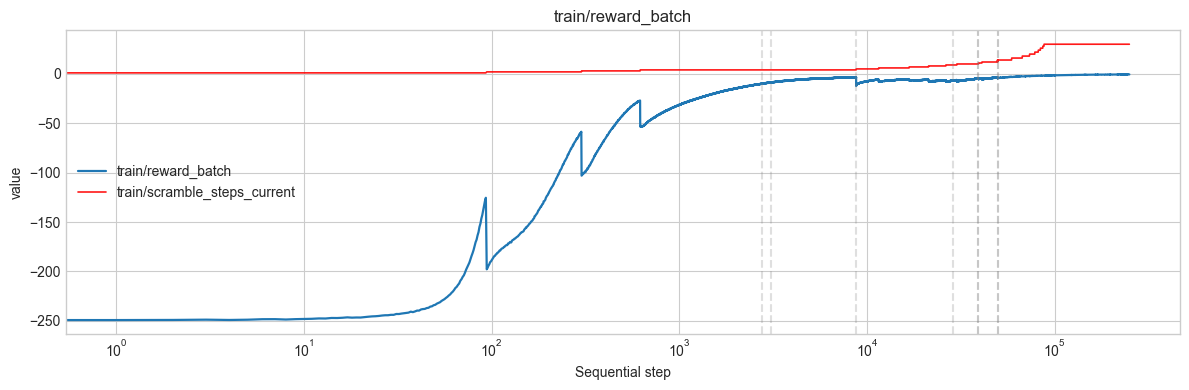

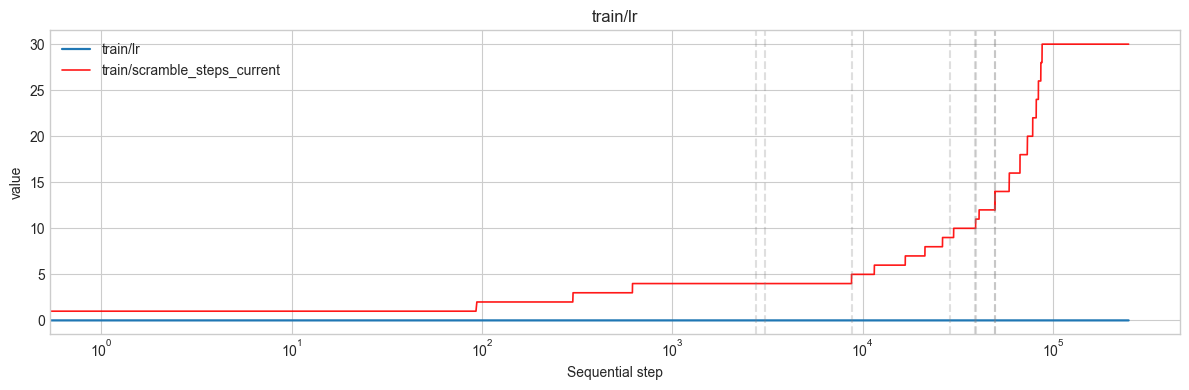

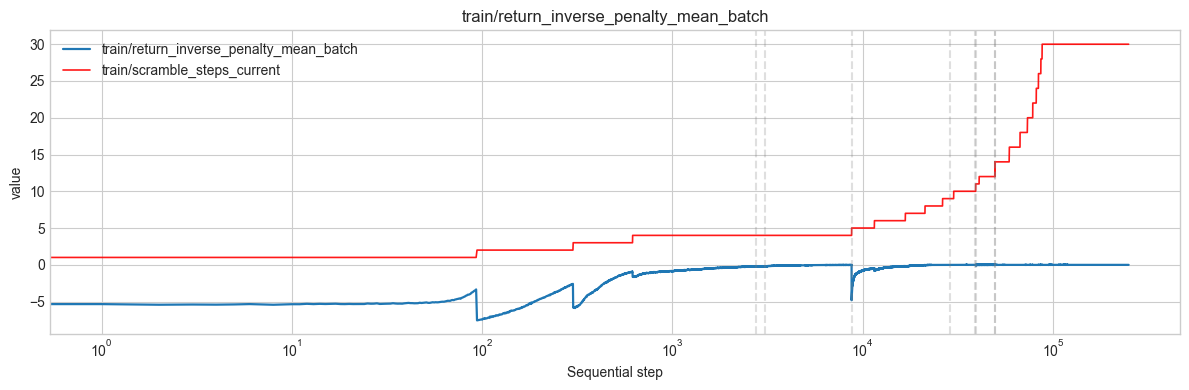

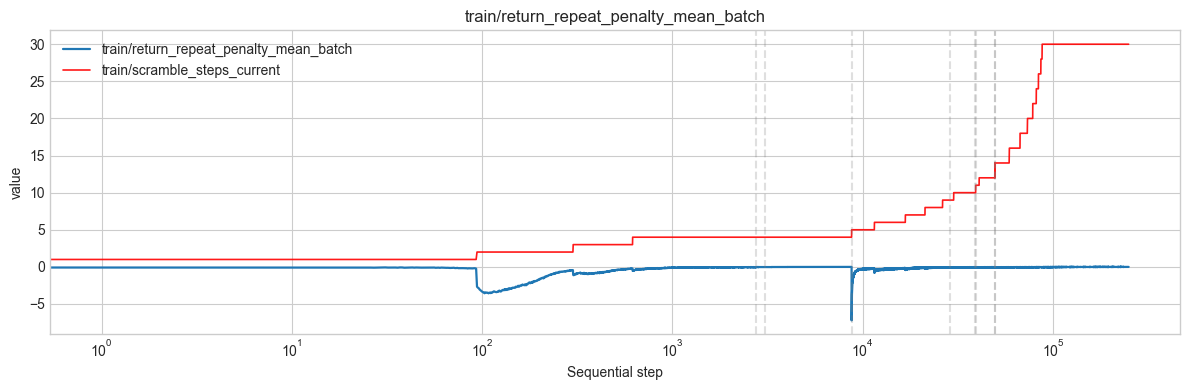

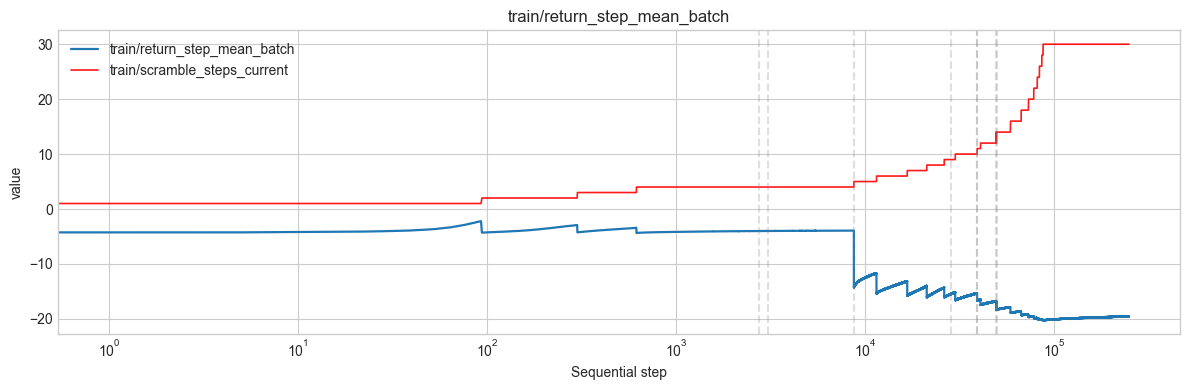

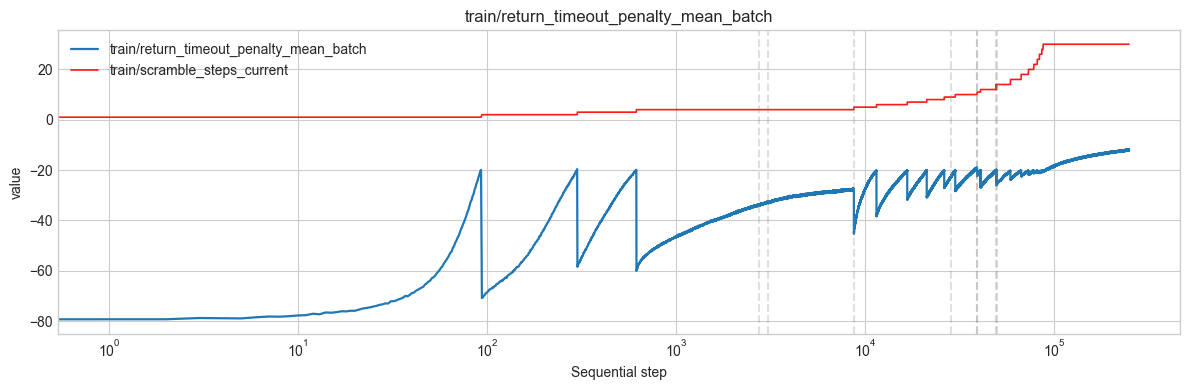

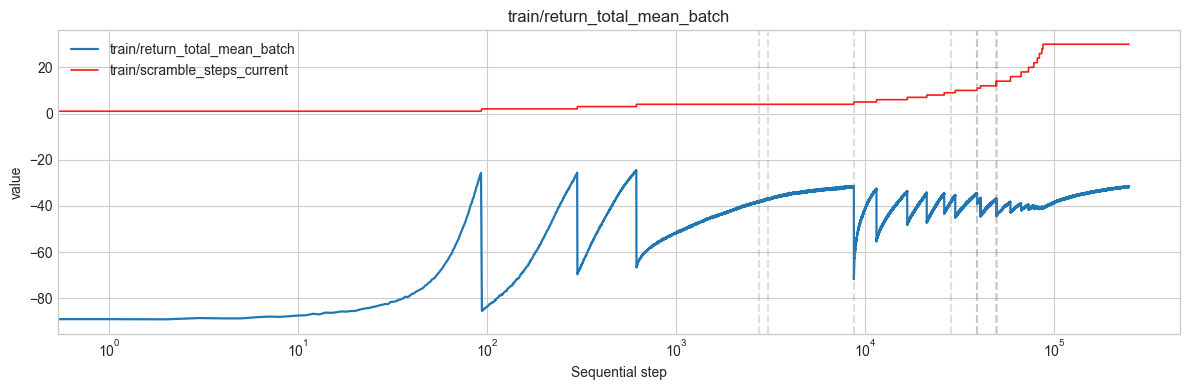

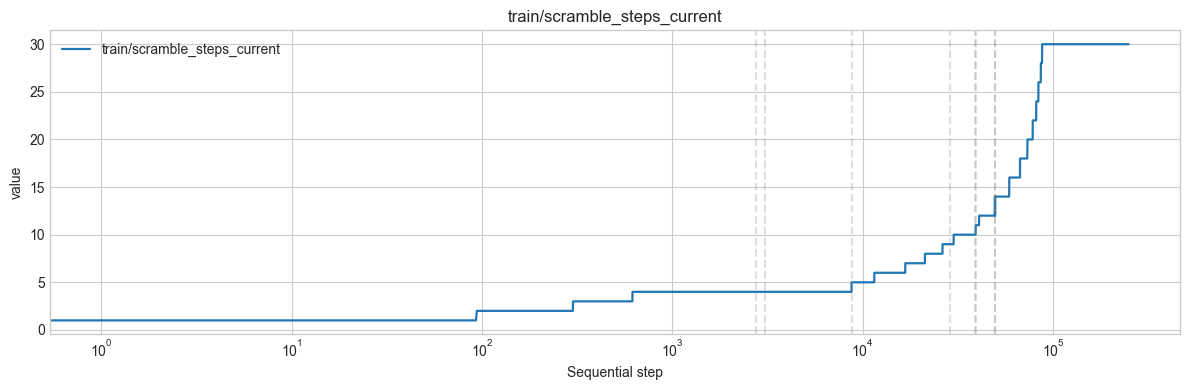

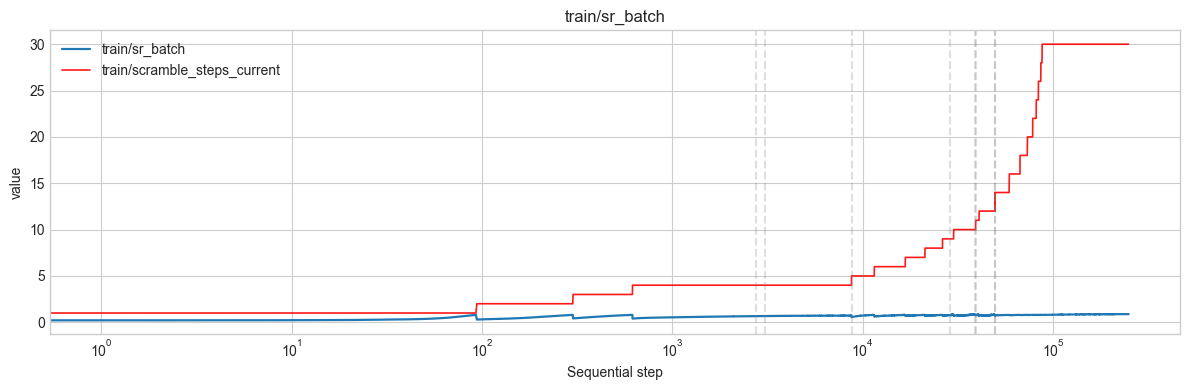

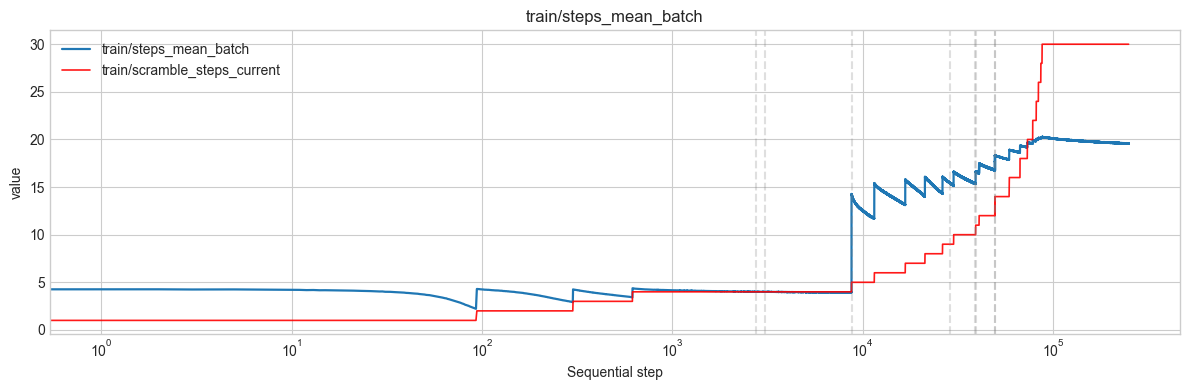

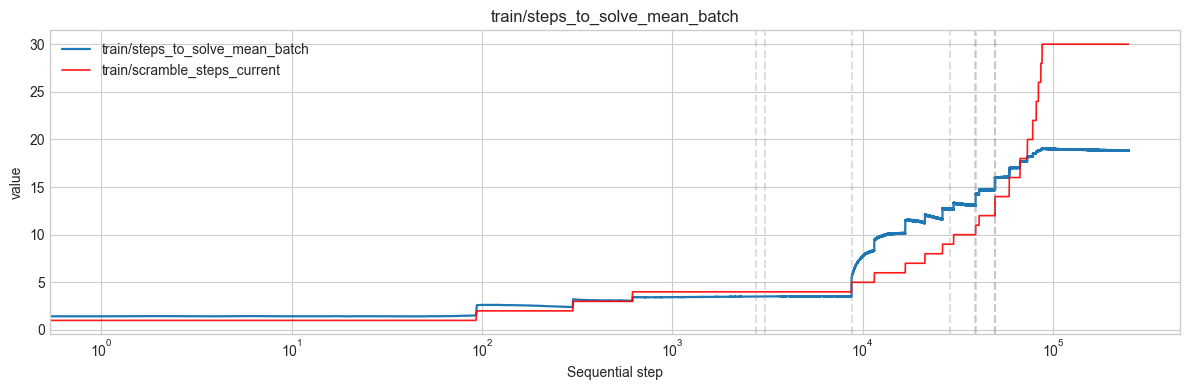

In [43]:
# Plot each tag in a separate figure
overlay_tag = 'train/scramble_steps_current'

for tag in sorted(stitched.keys()):
    x, y = stitched[tag]
    title = display_tag_name(tag)

    plt.figure(figsize=(12, 4))
    plt.plot(x, y, linewidth=1.6, label=display_tag_name(tag))

    # Overlay scramble_steps on every figure (except when current tag is the same)
    if overlay_tag in stitched and tag != overlay_tag:
        x_scr, y_scr = stitched[overlay_tag]
        plt.plot(x_scr, y_scr, color='red', linewidth=1.2, alpha=0.9, label=display_tag_name(overlay_tag))

    for b, _run_name in boundaries.get(tag, [])[1:]:
        plt.axvline(b, color='gray', linestyle='--', alpha=0.25)

    plt.title(title)
    plt.xlabel('Sequential step')
    plt.ylabel('value')
    plt.xscale('log')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
